In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
import pytorch_lightning as pl
import torchvision

In [3]:
#export
from exp.nb_02 import *

In [4]:
train_dl, valid_dl = get_dls(*get_ds(train_glob,valid_glob), bs = 8)
data = DataBunch(train_dl,valid_dl)
loss_func = nn.MSELoss()

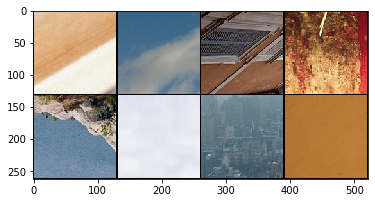

In [5]:
data.train_dl.show_batch()

In [6]:
pl.TrainResult??

In [7]:
pl.EvalResult??

In [55]:
class AE(pl.core.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self,x):
        return self.decoder(self.encoder(x))
    
    def training_step(self, batch, batch_idx):
        x = batch
        x_hat = self(x)
        loss = loss_func(x, x_hat)
        psnr = -10*torch.log10(loss)
        return {'loss':loss,'psnr':psnr}
    
    def training_epoch_end(self,training_step_outputs):
        # [results, results, results]
        avg_psnr = torch.stack([x['psnr'] for x in training_step_outputs]).mean()
        avg_loss = torch.stack([x['loss'] for x in training_step_outputs]).mean()
        self.logger.experiment.add_scalar('loss/avg_train',avg_loss,self.current_epoch)
        self.logger.experiment.add_scalar('psnr/train',avg_psnr,self.current_epoch)
        return avg_loss
    
    def validation_step(self, batch, batch_idx):
        x = batch
        x_hat = self(x)
        loss = loss_func(x, x_hat)
        psnr = -10*torch.log10(loss)
        return {'val_loss':loss,'psnr':psnr, 'x':x,'x_hat':x_hat}
    
    def validation_epoch_end(self,validation_step_outputs):
        # [results, results, results]
        avg_psnr = torch.stack([x['psnr'] for x in validation_step_outputs]).mean()
        avg_loss = torch.stack([x['val_loss'] for x in validation_step_outputs]).mean()
        x = validation_step_outputs[-1]['x']
        x_hat = validation_step_outputs[-1]['x_hat']
        x_grid = make_grid(x,5)
        x_hat_grid = make_grid(x_hat, 5)
        
        self.logger.experiment.add_image('val/original', x_grid, self.current_epoch)
        self.logger.experiment.add_image('val/reconstructions',x_hat_grid,self.current_epoch)
        self.logger.experiment.add_scalar('loss/avg_val',avg_loss,self.current_epoch)
        self.logger.experiment.add_scalar('psnr/val',avg_psnr,self.current_epoch)
        return {'val_loss':avg_loss}
    
    def train_dataloader(self):
        train_ds = ImageDataset(train_glob, 128)
        return DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4)
    
    def val_dataloader(self):
        valid_ds = ImageDataset(valid_glob, 128)
        return DataLoader(valid_ds, batch_size=5, shuffle=False, num_workers=4)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=3e-4)

In [56]:
model = AE()
trainer = pl.Trainer(gpus=1,max_epochs=1,)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


In [57]:
trainer.fit(model)


  | Name    | Type    | Params
------------------------------------
0 | encoder | Encoder | 2 M   
1 | decoder | Decoder | 3 M   


tensor(1.8340, device='cuda:0')
<class 'list'>
1
tensor([1.8340], device='cuda:0')


Saving latest checkpoint..


tensor(7.8238, device='cuda:0')
<class 'list'>
5
tensor([7.8238, 7.6096, 8.8903, 7.8433, 6.2751], device='cuda:0')



1